In [50]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:.4f}'.format


In [2]:
sample_dict = {
               'company':['A', 'A', 'A', 'A', 
                          'B', 'B', 'B', 
                          'C', 'C', 'C'], 
               'ipc_class':['A01E', 'B01F', 'C01G', 'D01H', 
                            'A01E', 'B02F', 'C01G', 
                            'A01E', 'B01F', 'B02F'],
               'reg_num':[3, 3, 7, 8, 
                          2, 9, 8, 
                          5, 2, 3]
               }

sample_df = pd.DataFrame(sample_dict)
sample_df


,company,ipc_class,reg_num
0,A,A01E,3
1,A,B01F,3
2,A,C01G,7
3,A,D01H,8
4,B,A01E,2
5,B,B02F,9
6,B,C01G,8
7,C,A01E,5
8,C,B01F,2
9,C,B02F,3


In [3]:
# ピボットテーブル作る関数
def make_pivot(input_data, ind, col, val):
    data = input_data[[ind, col, val]].copy()
    data = pd.pivot_table(data, index=ind, columns=col, values=val, aggfunc='sum')\
             .reset_index()\
             .set_index(ind)\
             .fillna(0)\
             .astype(np.float64)\
            #  .dropna(axis=1, how="all")
    return data


In [4]:
sample_pivot = make_pivot(sample_df, 'company', 'ipc_class', 'reg_num')
sample_pivot


ipc_class,A01E,B01F,B02F,C01G,D01H
company,,,,,
A,3.0,3.0,0.0,7.0,8.0
B,2.0,0.0,9.0,8.0,0.0
C,5.0,2.0,3.0,0.0,0.0


In [5]:
# RCAを求める関数
# 引数は，縦:国，横:商品のデータフレーム（ピボットテーブル）
def rca(tbl):
    # 計算の便宜上，はじめに欠損値を0で補完
    tbl = tbl.fillna(value=0)
    
    # 企業cの分野ipcの特許登録数
    col_sums = tbl.sum(axis='columns')
    col_sums = col_sums.to_numpy().reshape((len(col_sums), 1))
    # 企業cの分野ipcの特許登録数÷世界の分野ipcの特許登録数
    rca_numerator = np.divide(tbl, col_sums)

    # 企業cの分野ipcの特許登録数
    row_sums = tbl.sum(axis='index')
    # 世界の特許登録数
    total_sum = tbl.sum().sum()
    # 企業cの特許登録数÷世界の特許登録数
    rca_denominator = row_sums / total_sum

    rcas = rca_numerator / rca_denominator
    # 隣接行列作る
    rca_neighbor = rcas.copy()
    rca_neighbor[rca_neighbor >= 1] = 1
    rca_neighbor[rca_neighbor < 1] = 0
    rca_neighbor = rca_neighbor.fillna(0).astype(np.int64)
    return rcas, rca_neighbor


In [6]:
sample_rca = rca(sample_pivot)[1]
sample_rca


ipc_class,A01E,B01F,B02F,C01G,D01H
company,,,,,
A,0,1,0,1,1
B,0,0,1,1,0
C,1,1,1,0,0


In [7]:
sample_rca.to_numpy()

array([[0, 1, 0, 1, 1],
       [0, 0, 1, 1, 0],
       [1, 1, 1, 0, 0]], dtype=int64)

In [ ]:

# 複雑性求める関数
def kci(rca_df, iterations=20):
    """入力は，rca_df:隣接行列，iterations:繰り返し回数"""
    
    # 元データのコピーと転置行列の作成
    M_ci = rca_df.copy()
    M_ci_T = M_ci.copy().T
    kc_vec = [] # 企業の複雑性の配列
    ki_vec = [] # IPCの複雑性の配列
    
    kc_df_vec = [] # 企業の複雑性のデータフレームを格納する配列
    ki_df_vec = [] # IPCの複雑性のデータフレームを格納する配列
    
    # 初項の計算
    kc_0 = M_ci.sum(axis='columns') # 横方向に合計
    ki_0 = M_ci.sum(axis='index') # 縦方向に合計
    
    # 初項の格納
    kc_vec.append(kc_0)
    ki_vec.append(ki_0)
    
    # 初項のデータフレーム格納
    kc_df_vec.append(pd.DataFrame(kc_0, columns=['kci']).sort_values('kci', ascending=False).reset_index(drop=False))
    ki_df_vec.append(pd.DataFrame(ki_0, columns=['kci']).sort_values('kci', ascending=False).reset_index(drop=False))
    
    # ここから反映法(method of reflection)
    for n in range(1, iterations+1):
        kc_n = (M_ci @ ki_vec[n-1]) / kc_0
        ki_n = (M_ci_T @ kc_vec[n-1]) / ki_0
        
        kc_vec.append(kc_n)
        ki_vec.append(ki_n)
        
        kc_df_vec.append(pd.DataFrame(kc_n, columns=['kci']).sort_values('kci', ascending=False).reset_index(drop=False))
        ki_df_vec.append(pd.DataFrame(ki_n, columns=['kci']).sort_values('kci', ascending=False).reset_index(drop=False))
    # ここまで反映法
    
    return {'kc':kc_df_vec, 'ki':ki_df_vec}

    # com_complexity = (kc_n - kc_n.mean()) / kc_n.std()
    # pat_complexity = (ki_n - ki_n.mean()) / ki_n.std()
    # com_complexity_list = [(kc_n - kc_n.mean()) / kc_n.std() for kc_n in kc_vec]
    # pat_complexity_list = [(ki_n - ki_n.mean()) / ki_n.std() for ki_n in ki_vec]
    # com_complexity_df_list = [pd.DataFrame(com_complexity, 
    #                                        columns=['kci'])\
    #                             .sort_values('kci', 
    #                                          ascending=False)\
    #                             .reset_index(drop=False) for com_complexity in com_complexity_list]
    # pat_complexity_df_list = [pd.DataFrame(pat_complexity, 
    #                                        columns=['kci'])\
    #                             .sort_values('kci', 
    #                                          ascending=False)\
    #                             .reset_index(drop=False) for pat_complexity in pat_complexity_list]
    # return {'com':com_complexity_df_list, 'pat':pat_complexity_df_list}


In [57]:
def kci_array(rca_adj: pd.pivot_table, 
              iteration: int):
    hr_list = list(rca_adj.index)
    ipc_list = list(rca_adj.columns)
    M_ci = rca_adj.copy().to_numpy()
    M_ci_T = M_ci.copy().T
    
    kc_vec = [] 
    ki_vec = []
    
    kc_0 = M_ci.sum(axis=1) # 横軸方向に合計
    kc_0 = kc_0.reshape((len(kc_0), 1))
    
    ki_0 = M_ci.sum(axis=0) # 縦軸方向に合計
    ki_0 = ki_0.reshape((len(ki_0), 1))
    
    kc_vec.append(kc_0)
    ki_vec.append(ki_0)
    
    for n in range(1, iteration+1):
        kc_n = np.divide(M_ci.copy() @ ki_vec[n-1].copy(), kc_0.copy())
        ki_n = np.divide(M_ci_T.copy() @ kc_vec[n-1].copy(), ki_0.copy())
        
        kc_vec.append(kc_n)
        ki_vec.append(ki_n)
    
    # Construct the matrices M_cc' and M_pp' using equation (8)
    M_cc = M_ci.dot(np.diag(1 / ki_0.flatten())).dot(M_ci_T)
    M_ii = M_ci_T.dot(np.diag(1 / kc_0.flatten())).dot(M_ci)

    # Calculate the eigenvectors and eigenvalues
    eigenvalues_cc, eigenvectors_cc = np.linalg.eig(M_cc)
    eigenvalues_ii, eigenvectors_ii = np.linalg.eig(M_ii)

    # Sort eigenvalues and select the eigenvectors associated with the second largest eigenvalue
    kc_hat = eigenvectors_cc[:, eigenvalues_cc.argsort()[-2]]
    qi_hat = eigenvectors_ii[:, eigenvalues_ii.argsort()[-2]]

    # Calculate the Economic Complexity Index (ECI) and Product Complexity Index (PCI)
    KCI_C = (kc_hat - np.mean(kc_hat)) / np.std(kc_hat)
    KCI_I = (qi_hat - np.mean(qi_hat)) / np.std(qi_hat)
    
    hr_df = pd.DataFrame(KCI_C, index=hr_list, columns=['KCI_C'])\
                        .reset_index(drop=False)\
                        .rename(columns={'index':'right_person_name'})
    ipc_df = pd.DataFrame(KCI_I, index=ipc_list, columns=['KCI_I'])\
                        .reset_index(drop=False)\
                        .rename(columns={'index':'ipc_class'})
    for n in range(0, iteration+1):
        hr_df[f'kc_{n}'] = kc_vec[n]
        ipc_df[f'kc_{n}'] = ki_vec[n]
    
    return {'hr':hr_df, 'ipc':ipc_df}

In [69]:
def calculate_eci_pci(M_cp, N):
    # Calculate initial diversity (k_c_0) and ubiquity (k_p_0)
    k_c_0 = np.sum(M_cp, axis=1)
    k_p_0 = np.sum(M_cp, axis=0)

    # Initialize k_c_N and k_p_N with the initial values
    k_c_N = k_c_0.copy()
    k_p_N = k_p_0.copy()

    # Iteratively update k_c_N and k_p_N
    for iteration in range(N):
        k_c_N = (1 / k_c_0) * M_cp.dot(k_p_N)
        k_p_N = (1 / k_p_0) * M_cp.T.dot(k_c_N)

    # Construct the matrices M_cc' and M_pp' using equation (8)
    M_cc = M_cp.dot(np.diag(1 / k_p_0)).dot(M_cp.T)
    M_pp = M_cp.T.dot(np.diag(1 / k_c_0)).dot(M_cp)

    # Calculate the eigenvectors and eigenvalues
    eigenvalues_cc, eigenvectors_cc = np.linalg.eig(M_cc)
    eigenvalues_pp, eigenvectors_pp = np.linalg.eig(M_pp)

    # Sort eigenvalues and select the eigenvectors associated with the second largest eigenvalue
    k_c_hat = eigenvectors_cc[:, eigenvalues_cc.argsort()[-2]]
    q_p_hat = eigenvectors_pp[:, eigenvalues_pp.argsort()[-2]]

    # Calculate the Economic Complexity Index (ECI) and Product Complexity Index (PCI)
    ECI = (k_c_hat - np.mean(k_c_hat)) / np.std(k_c_hat)
    PCI = (q_p_hat - np.mean(q_p_hat)) / np.std(q_p_hat)
    
    return k_c_N, k_p_N, ECI, PCI
    return ECI, PCI

# Example usage
# M_cp = np.array([[...]])  # Your c x p adjacency matrix here
# N = ...  # Number of iterations
# ECI, PCI = calculate_eci_pci(M_cp, N)


In [70]:
calculate_eci_pci(sample_rca.to_numpy(), 2)

(array([1.72222222, 1.83333333, 1.72222222]),
 array([1.72222222, 1.72222222, 1.77777778, 1.77777778, 1.72222222]),
 array([-1.22474487e+00, -4.12824447e-16,  1.22474487e+00]),
 array([-1.11803399e+00,  2.76232897e-16, -1.11803399e+00,  1.11803399e+00,
         1.11803399e+00]))

In [58]:
kci_array(sample_rca, 20)['hr']

,right_person_name,KCI_C,kc_0,kc_1,kc_2,kc_3,kc_4,kc_5,kc_6,kc_7,...,kc_11,kc_12,kc_13,kc_14,kc_15,kc_16,kc_17,kc_18,kc_19,kc_20
0,A,-1.2247,3,1.6667,2.8333,1.7222,2.7778,1.7407,2.7593,1.7469,...,1.7497,2.7503,1.7499,2.7501,1.7500,2.7500,1.7500,2.7500,1.7500,2.7500
1,B,-0.0000,2,2.0000,2.5000,1.8333,2.6667,1.7778,2.7222,1.7593,...,1.7510,2.7490,1.7503,2.7497,1.7501,2.7499,1.7500,2.7500,1.7500,2.7500
2,C,1.2247,3,1.6667,2.8333,1.7222,2.7778,1.7407,2.7593,1.7469,...,1.7497,2.7503,1.7499,2.7501,1.7500,2.7500,1.7500,2.7500,1.7500,2.7500


In [8]:

# 複雑性求める関数
def kci(rca_df: pd.pivot_table, 
        iterations: int=20):
    """入力は，rca_df:隣接行列，iterations:繰り返し回数"""
    
    # 元データのコピーと転置行列の作成
    M_ci = rca_df.copy()
    M_ci_T = M_ci.copy().T
    kc_vec = [] # 企業の複雑性の配列
    ki_vec = [] # IPCの複雑性の配列
    
    kc_df_vec = [] # 企業の複雑性のデータフレームを格納する配列
    ki_df_vec = [] # IPCの複雑性のデータフレームを格納する配列
    
    # 初項の計算
    kc_0 = M_ci.sum(axis='columns') # 横方向に合計
    ki_0 = M_ci.sum(axis='index') # 縦方向に合計
    
    # 初項の格納
    kc_vec.append(kc_0)
    ki_vec.append(ki_0)
    
    # 初項のデータフレーム格納
    kc_df_vec.append(pd.DataFrame(kc_0, columns=['kci']).sort_values('kci', ascending=False).reset_index(drop=False))
    ki_df_vec.append(pd.DataFrame(ki_0, columns=['kci']).sort_values('kci', ascending=False).reset_index(drop=False))
    
    # ここから反映法(method of reflection)
    for n in range(1, iterations+1):
        kc_n = (M_ci @ ki_vec[n-1]) / kc_0
        ki_n = (M_ci_T @ kc_vec[n-1]) / ki_0
        
        kc_vec.append(kc_n)
        ki_vec.append(ki_n)
        
        kc_df_vec.append(pd.DataFrame(kc_n, columns=['kci']).sort_values('kci', ascending=False).reset_index(drop=False))
        ki_df_vec.append(pd.DataFrame(ki_n, columns=['kci']).sort_values('kci', ascending=False).reset_index(drop=False))
    # ここまで反映法
    
    return {'kc':kc_df_vec, 'ki':ki_df_vec}


In [12]:
sample_dict = kci(sample_rca, iterations=20)
sample_dict['kc'][2]

company
A    2.833333
B    2.500000
C    2.833333
dtype: float64

In [3]:
import numpy as np
list(np.random.randint(200, 500, (4*6)))

[243,
 292,
 5,
 23,
 264,
 401,
 229,
 250,
 401,
 139,
 193,
 201,
 133,
 435,
 234,
 300,
 274,
 287,
 290,
 336,
 57,
 45,
 220,
 318]

In [3]:
import pandas as pd
sample_time_dict = {
               'month':sorted([7, 8, 9, 10, 11, 12]*4), 
               'item':['A', 'B', 'C', 'D'] * 6, 
               'num':list(np.random.randint(200, 500, (4*6)))
               }

sample_time_df = pd.DataFrame(sample_time_dict)
sample_time_df


,month,item,num
0,7,A,382
1,7,B,374
2,7,C,334
3,7,D,208
4,8,A,216
5,8,B,298
6,8,C,402
7,8,D,303
8,9,A,344
9,9,B,479


In [4]:
import matplotlib.pyplot as plt
def rank(df, 
         period_col, 
         member_col,
         num_col, 
         prop_dict):
    """
    Args:
        df (pd.DataFrame): データフレーム
        period_col (str): 期間の列名
        member_col (str): メンバーの列名
        num_col (str): 数値の列名
        prop_dict (dict): プロパティの辞書．['figsize', 'xlabel', 'title', 'colormap', 'rank']
    Returns:
        None
    """
    # for prop in ['figsize', 'xlabel', 'title', 'colormap', 'rank']:
    #     if prop not in prop_dict.keys():
    #         prop_dict[prop] = None
    #     if prop_dict['rank'] is None:
    #         prop_dict[prop] = 15
            # raise ValueError(f'Please specify {prop}')
    data_rank = df.copy(deep=True)
    data_rank['rank'] = df.groupby(period_col)[[num_col]]\
                          .rank(method='first',
                                ascending=False)\
                          .astype(np.int64)
    pivot_data_rank = data_rank.pivot_table(index=period_col,
                                            columns=member_col,
                                            values='rank')
    first_top_rank_list = list(pivot_data_rank.iloc[0, :].sort_values(ascending=True).copy().index[:int(prop_dict['rank'])])
    last_top_rank_list = list(pivot_data_rank.iloc[len(pivot_data_rank)-1, :].sort_values(ascending=True).copy().index[:int(prop_dict['rank'])])
    display(pivot_data_rank)
    display(first_top_rank_list)
    display(last_top_rank_list)
    
    fig = plt.figure(figsize=prop_dict['figsize'])
    ax1 = fig.add_subplot(1, 1, 1)
    ax2 = ax1.twinx()
    
    # pivot_data_rank.plot(style='o-', markersize=15, ax=ax2, 
    #                      fontsize=15, xlabel=prop_dict['xlabel'], rot=90,
    #                      colormap=prop_dict['colormap'])
    ax1.plot(pivot_data_rank.index, pivot_data_rank)
    
    # ax1.set_xticks(range(0, len(pivot_data_rank)))
    # ax1.set_xticklabels(pivot_data_rank.index, fontsize=15)
    
    # plt.xticks(range(0, len(pivot_data_rank)), pivot_data_rank.index, fontsize=15, rotation=90)
    
    # ax1.set_ylim(0, int(prop_dict['rank']))
    ax1.set_yticks(range(0, int(prop_dict['rank'])))
    ax1.set_yticklabels(first_top_rank_list, fontsize=15)
    
    ax2.set_yticks(range(0, int(prop_dict['rank'])))
    ax2.set_yticklabels(last_top_rank_list, fontsize=15)
    # fig, ax = plt.subplots(1, 1, figsize=prop_dict['figsize'])
    # pivot_data_rank.plot(style='o-', markersize=15, ax=ax1, 
    #                      fontsize=15, xlabel=prop_dict['xlabel'], rot=90,
    #                      colormap=prop_dict['colormap'])
    plt.title(prop_dict['title'], fontsize=24)
    [s.set_visible(False) for s in ax1.spines.values()]
    # ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=15)
    # ax1.set_yticks([y for y in range(1, int(prop_dict['rank'])+1)], fontsize=15)
    # fig.tight_layout()
    # ax1.invert_yaxis()
    
    return None

C:\Users\rin\AppData\Local\Temp\ipykernel_1060\1445817769.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_major_formatter(FixedFormatter(top_sources["source"].to_list()))


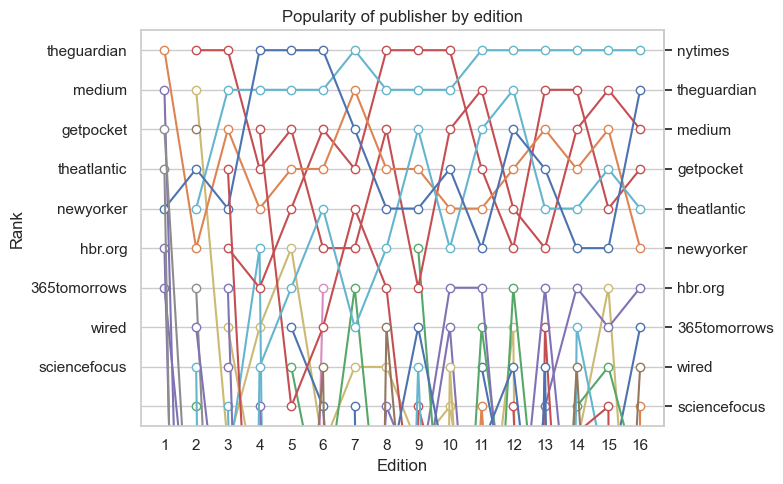

In [61]:
import pandas as pd

data_source = (
    "https://gist.githubusercontent.com/"
    "notionparallax/7ada7b733216001962dbaa789e246a67/raw/"
    "6d306b5d928b04a5a2395469694acdd8af3cbafb/example.csv"
)

df = (
    pd.read_csv(data_source, index_col=0)
    .assign(ed_name=lambda x: x["ed_name"].str.extract(r"(\d+)").astype(int))
    .value_counts(["ed_name", "source"])
    .groupby("ed_name")
    .rank("first", ascending=False)
    .rename("rank")
    .sort_index()
    .reset_index()
    .query("ed_name < 17")
)

n_top_ranked = 10
top_sources = df[df["ed_name"] == df["ed_name"].max()].nsmallest(n_top_ranked, "rank")
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator

fig, ax = plt.subplots(figsize=(8, 5), subplot_kw=dict(ylim=(0.5, 0.5 + n_top_ranked)))

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_formatter(FixedFormatter(top_sources["source"].to_list()))

yax2 = ax.secondary_yaxis("right")
yax2.yaxis.set_major_locator(FixedLocator(top_sources["rank"].to_list()))
yax2.yaxis.set_major_formatter(FixedFormatter(top_sources["source"].to_list()))

for i, j in df.groupby("source"):
    ax.plot("ed_name", "rank", "o-", data=j, mfc="w")

ax.invert_yaxis()
ax.set(xlabel="Edition", ylabel="Rank", title="Popularity of publisher by edition")
ax.grid(axis="x")
plt.tight_layout()

In [3]:
import pandas as pd

data_source = (
    "https://gist.githubusercontent.com/"
    "notionparallax/7ada7b733216001962dbaa789e246a67/raw/"
    "6d306b5d928b04a5a2395469694acdd8af3cbafb/example.csv"
)

df = (
    pd.read_csv(data_source, index_col=0)
    .assign(ed_name=lambda x: x["ed_name"].str.extract(r"(\d+)").astype(int))
    .value_counts(["ed_name", "source"])
    .groupby("ed_name")
    .rank("first", ascending=False)
    .rename("rank")
    .sort_index()
    .reset_index()
    .query("ed_name < 17")
)

n_top_ranked = 10
top_sources = df[df["ed_name"] == df["ed_name"].max()].nsmallest(n_top_ranked, "rank")
top_sources


,ed_name,source,rank
4985,16,nytimes,1.0
5081,16,theguardian,2.0
4949,16,medium,3.0
4859,16,getpocket,4.0
5071,16,theatlantic,5.0
4976,16,newyorker,6.0
4874,16,hbr.org,7.0
4710,16,365tomorrows,8.0
5132,16,wired,9.0
5031,16,sciencefocus,10.0


In [9]:
sample_time_copy_df = sample_time_df.copy()
sample_time_copy_df['rank'] = sample_time_copy_df.groupby('month')['num']\
                                                 .rank('first', ascending=False)
sample_time_copy_df = sample_time_copy_df.sort_values(['month', 'rank'], ascending=True)
sample_time_copy_df[sample_time_copy_df['month']==sample_time_copy_df['month'].max()]#.nsmallest(4, 'rank')

,month,item,num,rank
23,12,D,466,1.0
20,12,A,291,2.0
22,12,C,284,3.0
21,12,B,254,4.0


In [7]:

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator

def rank_doubleaxis(df, 
                    rank_num: int, 
                    period_col: str, 
                    member_col: str, 
                    num_col: str, 
                    prop_dict: dict={
                                     'figsize':(8, 5), 
                                     'xlabel':'Segment', 
                                     'ylabel':'y軸のラベル', 
                                     'title':'タイトル', 
                                     'fontsize':15
                                     }):
    plt.rcParams['font.size'] = prop_dict['fontsize']
    plt.rcParams['font.family'] = 'Meiryo'
    
    rank_df = df.copy()
    rank_df['rank'] = rank_df.groupby(period_col)[num_col].rank('first', ascending=False)
    rank_df['segment'] = rank_df[period_col].str[:4].astype(np.int64)
    rank_df = rank_df.sort_values(['segment', 'rank'], ascending=True)
    # rank_df = rank_df.sort_values([period_col, 'rank'], ascending=True)
    first_top_sources = rank_df[(rank_df['segment'] == rank_df['segment'].min())\
                           &(rank_df['rank']<=rank_num)]
    
    last_top_sources = rank_df[(rank_df['segment'] == rank_df['segment'].max())\
                           &(rank_df['rank']<=rank_num)]
    
    fig, ax = plt.subplots(figsize=prop_dict['figsize'], 
                           subplot_kw=dict(ylim=(0.5, 0.5 + rank_num))
                           )
    plt.xticks(range(0, 900, 100), list(rank_df[period_col].unique()), rotation=90)
    
    # 左側の軸
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(FixedLocator(first_top_sources['rank'].to_list()))
    ax.yaxis.set_major_formatter(FixedFormatter(first_top_sources[member_col].to_list()))
    
    # 右側の軸
    yax2 = ax.secondary_yaxis('right')
    yax2.yaxis.set_major_locator(FixedLocator(last_top_sources['rank'].to_list()))
    yax2.yaxis.set_major_formatter(FixedFormatter(last_top_sources[member_col].to_list()))
    colors_list = [
    'red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black',
    'purple', 'orange', 'pink', 'lime', 'brown', 'gold', 'silver',
    'darkred', 'darkgreen', 'darkblue', 'darkcyan', 'darkmagenta',
    'lightcoral', 'lightgreen', 'lightblue', 'lightpink',
    'lightyellow', 'gray', 'darkgray', 'lightgray', 'olive', 'teal'
    ][::]


    member_color_dict = dict(zip(first_top_sources[member_col].to_list()+last_top_sources[member_col].to_list(), 
                                 colors_list))
    
    for i, j in rank_df.groupby(member_col):
        # ax.plot(period_col, 'rank', 'o-', data=j, linewidth=3, markersize=10)
        if i in first_top_sources[member_col].to_list():
            ax.plot('segment', 'rank', 'o-', data=j, linewidth=3, markersize=10, 
                    color=member_color_dict[i])
        else: ax.plot('segment', 'rank', 'o-', data=j, linewidth=3, markersize=10)
        # print(i)
        # display(j)

    ax.invert_yaxis()
    ax.set(xlabel='\n'+prop_dict['xlabel'], 
           ylabel=prop_dict['ylabel']+'\n', 
           title=prop_dict['title']
           )
    # [s.set_visible(False) for s in ax.spines.values()]
    ax.grid(axis='both', linestyle='--', c='lightgray')
    [s.set_visible(False) for s in ax.spines.values()]
    [s.set_visible(False) for s in yax2.spines.values()]
    plt.xticks(range(rank_df['segment'].min(), rank_df['segment'].max()+1, 5), 
               list(rank_df[period_col].unique()), rotation=90)
    plt.tight_layout()
    
    return rank_df

In [137]:
# sample_app_df = pd.read_csv('app_sample_100.csv')
sample_app_df = pd.read_csv('app_sample_30.csv')
sample_app_df

,period,right_person_name,reg_num
0,1971-1975,パナソニツクホールデイングス株式会社,17367
1,1971-1975,株式会社日立製作所,15547
2,1971-1975,株式会社東芝,7285
3,1971-1975,日本製鉄株式会社,5050
4,1971-1975,三菱電機株式会社,4911
...,...,...,...
265,2011-2015,ＪＦＥスチール株式会社,4531
266,2011-2015,京楽産業．株式会社,4301
267,2011-2015,ソニーグループ株式会社,4235
268,2011-2015,オリンパス株式会社,4133


In [90]:
# sample_time_df

In [3]:
prop_dict = {'figsize':(20, 12), 
             'xlabel':'期間', 
             'ylabel':'', 
             'title':'1971-2015年における登録数のランキングTop10推移（出願年基準，N=0）', 
             'fontsize':20}

sample_rank = rank_doubleaxis(
         sample_app_df, 
         10, # rank_num
         'period', # period_col
         'right_person_name', # member_col
         'reg_num', # num_col
         prop_dict)

# sample_rank[sample_rank['period']=='2006-2010']

NameError: name 'sample_app_df' is not defined

In [10]:
sample_kci_df = pd.read_csv('app_sample_kci30.csv')

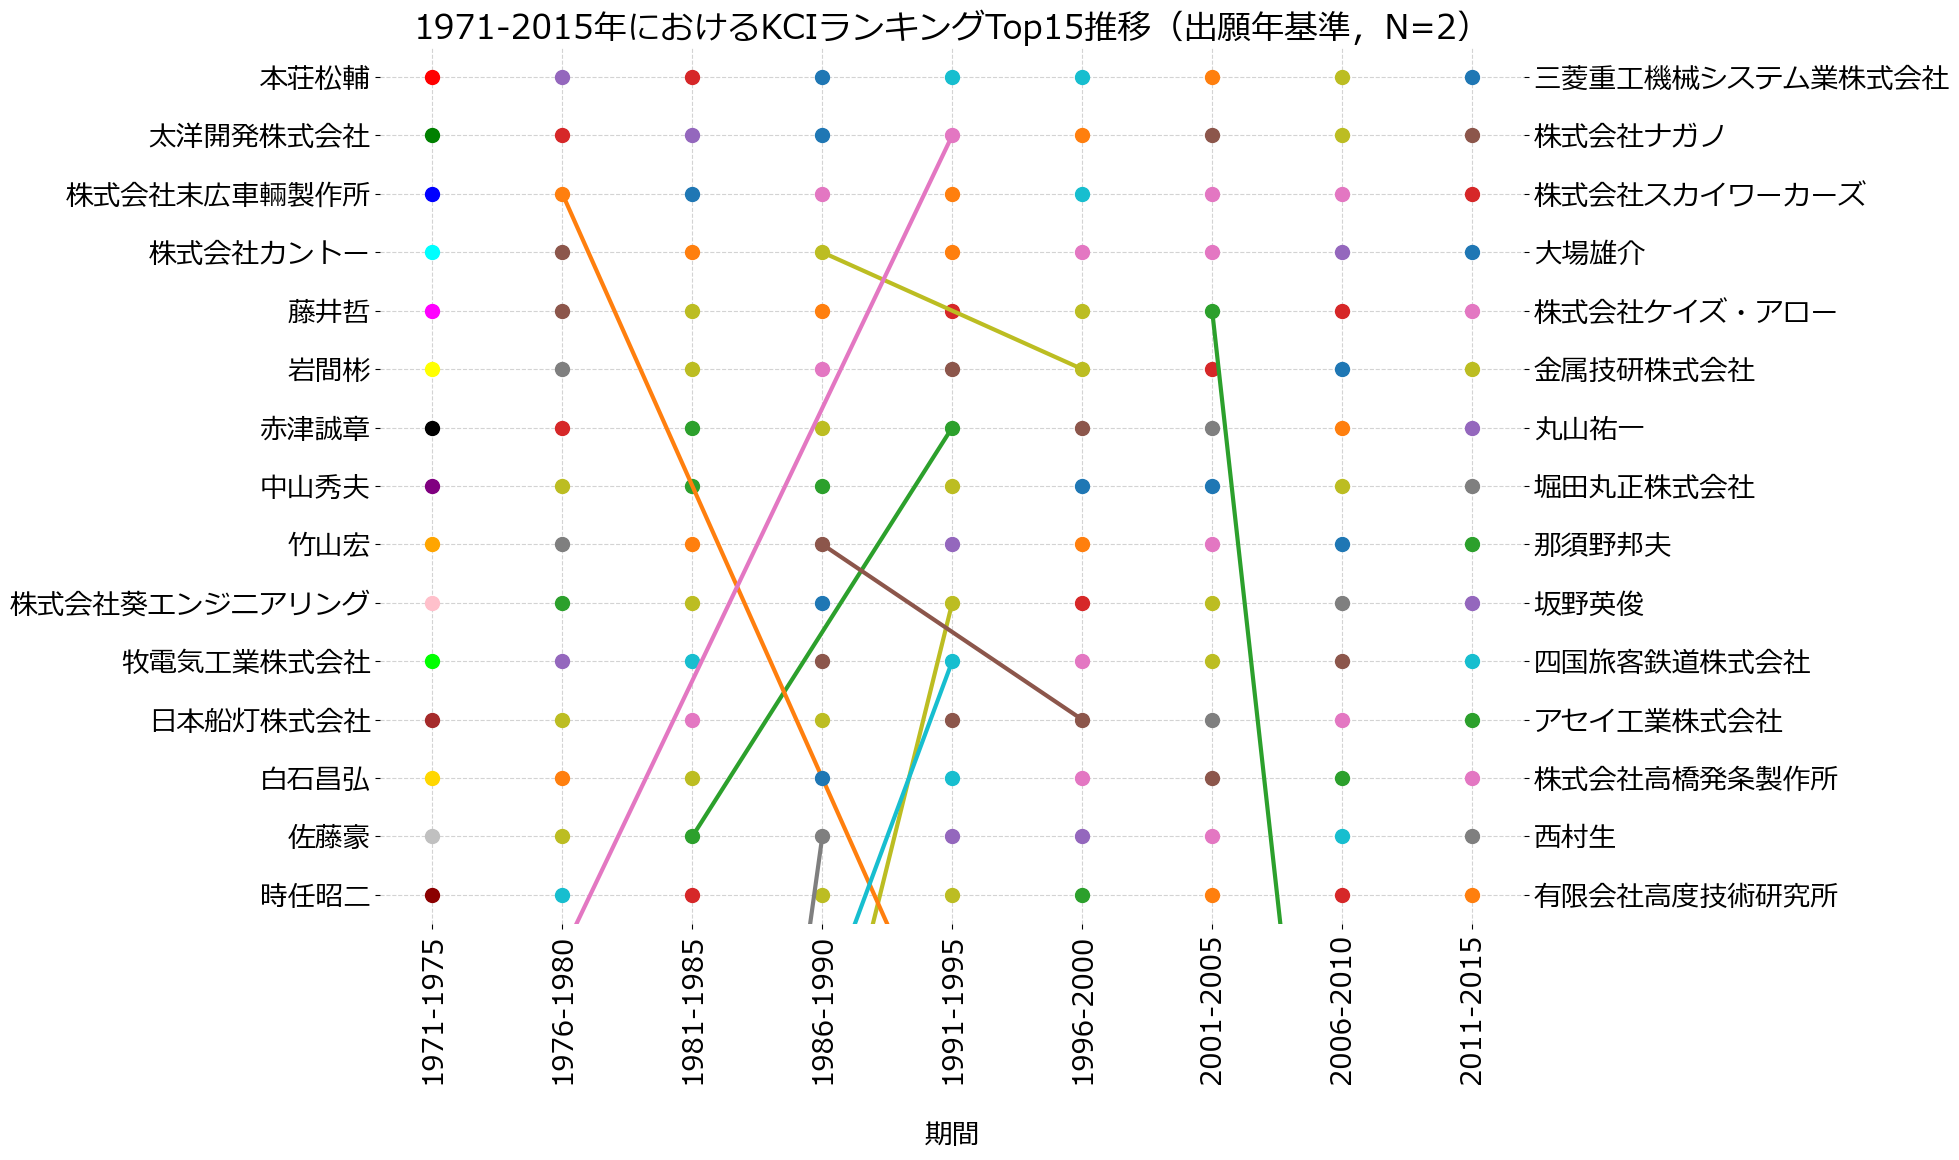

In [13]:
prop_dict = {'figsize':(20, 12), 
             'xlabel':'期間', 
             'ylabel':'', 
             'title':'1971-2015年におけるKCIランキングTop15推移（出願年基準，N=2）', 
             'fontsize':20}

sample_rank = rank_doubleaxis(
         sample_kci_df, 
         15, # rank_num
         'period', # period_col
         'right_person_name', # member_col
         'kci', # num_col
         prop_dict)

In [ ]:
# RCAを求める関数
# 引数は，縦:国，横:商品のデータフレーム（ピボットテーブル）
def rca(tbl: pd.pivot_table):
    """_summary_

    Args:
        tbl (_pd.pivot_table_): _縦:国，横:商品のピボットテーブル_

    Returns:
        tuple (_tuple(pd.pivot_table, pd.pivot_table)_): _description_
    """
    # 計算の便宜上，はじめに欠損値を0で補完
    tbl = tbl.fillna(value=0)
    
    # 企業cの分野ipcの特許登録数
    col_sums = tbl.sum(axis='columns')
    col_sums = col_sums.to_numpy().reshape((len(col_sums), 1))
    # 企業cの分野ipcの特許登録数÷世界の分野ipcの特許登録数
    rca_numerator = np.divide(tbl, col_sums)

    # 企業cの分野ipcの特許登録数
    row_sums = tbl.sum(axis='index')
    # 世界の特許登録数
    total_sum = tbl.sum().sum()
    # 企業cの特許登録数÷世界の特許登録数
    rca_denominator = row_sums / total_sum

    rcas = rca_numerator / rca_denominator
    rcas = rcas.fillna(0).astype(np.float64)
    return rcas

def rca_adj(rca: pd.pivot_table, 
            threshold: float = 1.0):
    """_summary_

    Args:
        rca (pd.pivot_table): RCA行列
        threshold (float, optional): 次数削減の閾値. Defaults to 1.0.

    Returns:
        rca_neighbor: RCA隣接行列
    """
    # 隣接行列作る
    rcas_neighbor = rca.copy()
    rcas_neighbor[rcas_neighbor < threshold] = 0
    rcas_neighbor[rcas_neighbor >= threshold] = 1
    rcas_neighbor = rcas_neighbor.fillna(0).astype(np.int64)
    
    return rcas_neighbor

In [59]:
sample_rca_df = rca(sample_pivot)[0]
sample_rca_df


ipc_class,A01E,B01F,B02F,C01G,D01H
company,,,,,
A,0.714286,1.428571,0.000000,1.111111,2.380952
B,0.526316,0.000000,1.973684,1.403509,0.000000
C,2.500000,2.000000,1.250000,0.000000,0.000000


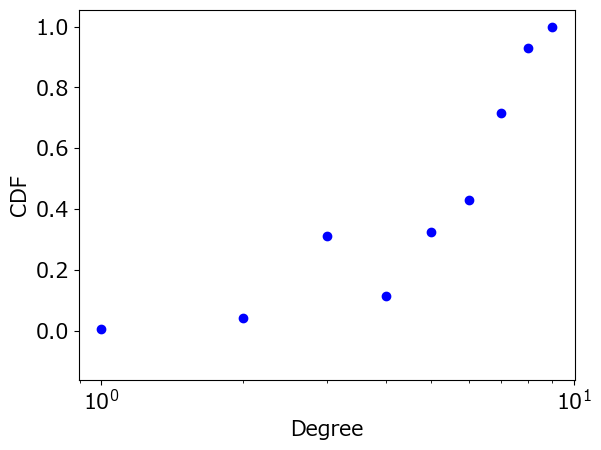

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

sample_array = sample_rca_df.to_numpy()
sample_log_array = np.log(sample_array[sample_array!=0])
# log_values = np.log(non_zero_values)
sample_log_array = np.round(sample_log_array, 2)
s = float(sample_log_array.sum())
cdf = sample_log_array.cumsum(0) / s
# print(cdf)
plt.plot(range(len(cdf)), cdf, 'bo')
plt.xscale('log')
# plt.ylim([0, 1])
plt.ylabel('CDF', fontsize=15)
plt.xlabel('Degree', fontsize=15)
plt.show()

In [26]:
# 複雑性求める関数
def eci_pci(M_cp, iterations=20):    
    kc_vec = []
    kp_vec = []
    
    kc_df_vec = []
    kp_df_vec = []
    
    kc_0 = M_cp.sum(axis='columns') #sum rows
    kp_0 = M_cp.sum(axis='index') #sum columns
    
    kc_vec.append(kc_0)
    kp_vec.append(kp_0)
    
    kc_df_vec.append(pd.DataFrame(kc_0, columns=['kci']).sort_values('kci', ascending=False).reset_index(drop=False))
    kp_df_vec.append(pd.DataFrame(kp_0, columns=['kci']).sort_values('kci', ascending=False).reset_index(drop=False))
    for n in range(1, iterations):
        kc_n = (M_cp @ kp_vec[n-1].T) / kc_0
        kp_n = (M_cp.T @ kc_vec[n-1]) / kp_0
        
        kc_vec.append(kc_n)
        kp_vec.append(kp_n)
        
        kc_df_vec.append(pd.DataFrame(kc_n, columns=['kci']).sort_values('kci', ascending=False).reset_index(drop=False))
        kp_df_vec.append(pd.DataFrame(kp_n, columns=['kci']).sort_values('kci', ascending=False).reset_index(drop=False))
    
    return {'kc':kc_df_vec, 'kp':kp_df_vec}

    # com_complexity = (kc_n - kc_n.mean()) / kc_n.std()
    # pat_complexity = (kp_n - kp_n.mean()) / kp_n.std()
    # com_complexity_list = [(kc_n - kc_n.mean()) / kc_n.std() for kc_n in kc_vec]
    # pat_complexity_list = [(kp_n - kp_n.mean()) / kp_n.std() for kp_n in kp_vec]
    # com_complexity_df_list = (pd.DataFrame(com_complexity, 
    #                                        columns=['kci'])\
    #                             .sort_values('kci', 
    #                                          ascending=False)\
    #                             .reset_index(drop=False) for com_complexity in com_complexity_list)
    # pat_complexity_df_list = (pd.DataFrame(pat_complexity, 
    #                                        columns=['kci'])\
    #                             .sort_values('kci', 
    #                                          ascending=False)\
    #                             .reset_index(drop=False) for pat_complexity in pat_complexity_list)
    # return {'com':com_complexity_df_list, 'pat':pat_complexity_df_list}


In [ ]:
def network_degree(graph: nx.Graph, 
            node_list: list, 
            prop_dict: dict):
    """ Plot network
    Args:
        graph (nx.Graph): graph
        node_list (list): list of nodes
        prop_dict (dict): dictionary of properties
    Returns:
        None
    """
    
    node_degree_dict = dict(bip.degrees(graph, node_list)[1])
    freq_list = list(np.bincount(list(node_degree_dict.values())))

    # """ Plot Distribution """
    # plt.plot(range(len(freq_list)), freq_list, 'bo')
    # plt.yscale('log')
    # plt.xscale('log')
    # plt.ylabel('Freq', fontsize=15)
    # plt.xlabel('Degree', fontsize=15)
    # plt.show()

    # """ Plot CDF """
    s = float(freq_list.sum())
    cdf = freq_list.cumsum(0) / s
    # plt.plot(range(len(cdf)), cdf, 'bo')
    # plt.xscale('log')
    # plt.ylim([0, 1])
    # plt.ylabel('CDF', fontsize=15)
    # plt.xlabel('Degree', fontsize=15)
    # plt.show()

    """ Plot CCDF """
    ccdf = 1-cdf
    plt.plot(range(len(ccdf)), ccdf, 'bo')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim([0, 1])
    plt.ylabel('CCDF', fontsize=15)
    plt.xlabel('Degree', fontsize=15)
    plt.show()

    return None